### Some Analysis of the NOAA weather dataset ###

In this notebook we are analyzing a sample out of data that was downloaded from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/, the main file is ghcnd_all.tar.gz which is about 2.4 GB which becomes around 20GB when uncompressed.

The data contains about 1 million station-year recordings. That is too much to analyzer on single core machine, so we start by taking a sample of 20,000 recordings of the maximal daily temperatures for a period of a 365 days starting on January 1st (the last day of leap years is discarded).

### Checking the versions of some important packages ###

In [1]:
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages
Requirement already up-to-date: cycler in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from matplotlib)
Requirement already up-to-date: pytz in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from matplotlib)
Requirement already up-to-date: numpy>=1.6 in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,>=1.5.6 in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from matplotlib)
Requirement already up-to-date: six in /Users/pauldefusco/anaconda2/lib/python2.7/site-packages (from cycler->matplotlib)
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
%pylab inline
print 'pandas version: ',pd.__version__
print 'numpy version:',np.__version__
print 'sklearn version:',sk.__version__
print 'matplotlib version:', matplotlib.__version__

Populating the interactive namespace from numpy and matplotlib
pandas version:  0.18.1
numpy version: 1.11.2
sklearn version: 0.17.1
matplotlib version: 1.5.3


Switch to the data directory and check it's contents

In [3]:
%cd ../data/weather
#%cd ~/BigData/UCSD_BigData_2016/data/weather/    
#%cs ~/data/weather
!ls -lh

/Users/pauldefusco/Documents/DSE/pdefusco/DSE200/data/weather
total 159696
-rw-r--r--  1 pauldefusco  staff   839K Sep 22 20:06 ALL.corrupted.csv
-rw-r--r--  1 pauldefusco  staff   839K Sep 22 20:06 ALL.head.csv
-rw-r--r--  1 pauldefusco  staff    25M Sep 22 20:06 SAMPLE_TMAX.csv
-rw-r--r--  1 pauldefusco  staff    13K Sep 22 20:06 TMAX.10.csv
-rw-r--r--  1 pauldefusco  staff     0B Sep 22 20:06 TMAX.head.csv
-rw-r--r--  1 pauldefusco  staff   218B Sep 22 20:06 data-source.txt
-rw-r--r--  1 pauldefusco  staff    22K Sep 22 20:06 ghcnd-readme.txt
-rw-r--r--  1 pauldefusco  staff   7.0M Sep 22 20:06 ghcnd-stations.txt
-rw-r--r--  1 pauldefusco  staff   7.4M Sep 22 20:06 ghcnd-stations_buffered.txt
-rw-r--r--  1 pauldefusco  staff   270B Sep 22 20:06 ghcnd-version.txt
-rw-r--r--  1 pauldefusco  staff    37M Sep 22 20:06 make_covar.raw_256


In [4]:
!cat data-source.txt

I got the data from this ftp site:

ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/

Opening the ftp site in a browser is helpful: you can easily browse the directory structure and look at txt and
pdf files.

Yoav Freund


- *data-source.txt* - information about downloading the data from NOAA
- *ghcnd-readme.txt* - A readme file describing the content of all of the files from ghcnd, in particular:
- *ghcnd-stations.txt* - information about each of the meteorological stations.
- *Sample_TMAX* - a file with 10,000 randomly selected one-year-long TMAX measurements

In [5]:
#!head -1 SAMPLE_TMAX.csv
# a Typical single line in the data file
file=open('SAMPLE_TMAX.csv','r')
for line in file.readlines():
    print line
    print len(line.split(','))
    break

USC00507570,TMAX,2005,67,44,61,17,-17,-22,-39,-44,-44,-78,-156,-156,-33,28,39,22,-89,-139,-156,44,61,50,-39,17,67,61,-61,-61,11,33,-72,-100,-150,-178,-150,-33,39,28,22,11,-150,-156,-150,50,44,28,39,50,56,39,67,50,39,56,50,56,44,22,6,17,17,61,83,67,67,89,78,61,61,83,56,44,67,89,67,89,100,83,56,17,22,50,39,28,-6,28,-6,-28,-50,-44,-33,-22,-22,-22,17,67,67,78,94,89,72,56,89,111,94,83,56,11,28,56,89,133,133,128,178,167,194,211,189,178,161,172,144,133,128,117,183,200,211,211,178,172,133,150,128,133,150,150,178,211,200,133,172,144,161,156,139,150,133,144,161,150,161,200,183,228,222,183,144,150,178,167,183,239,239,267,244,222,222,117,189,233,194,206,261,228,211,222,261,228,228,200,194,183,233,244,217,267,250,217,161,200,200,194,250,261,222,194,183,161,206,228,228,222,206,200,167,183,194,172,200,189,167,183,194,200,206,217,206,244,267,256,278,294,278,256,228,228,189,206,211,211,161,156,144,156,161,156,167,139,122,144,139,156,150,144,128,144,128,150,150,133,144,172,156,106,161,161,122,122,133,11

### read data into a Pandas Dataframe ##
* Read the data into a DataFrame
* Read the data vectors in G
* Divide by 10.0 to get the temperatude in degrees celsius
* Replace values outside the range [-400,500]  ([-40,50] degrees celsius) with nan  
* Paste fixed matrix back into Dout
* Show the first few lines of DDout

In [6]:
#using 2001 which was not a leap year (2000 was)
days_index=pd.date_range('January 1, 2001', periods=365,freq='D')
days=list(days_index)

In [7]:
# header=['station','measurement','year']+dates_in_year
columns=['station','measurement','year']+days
# D=pandas.DataFrame(columns=header)
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=columns)
Data.head()

,station,measurement,year,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,2001-01-07 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,TMAX,2005,67.0,44.0,61.0,17.0,-17.0,-22.0,-39.0,...,-39.0,-33.0,-17.0,39.0,61.0,50.0,61.0,61.0,44.0,61.0
1,NOE00135018,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,31.0,45.0,42.0,32.0,16.0,20.0,22.0,39.0,61.0
2,KZ000036546,TMAX,1982,NaN,NaN,-139.0,NaN,NaN,-45.0,NaN,...,NaN,-73.0,NaN,NaN,NaN,-170.0,-166.0,-160.0,-135.0,-99.0
3,USC00054664,TMAX,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.0,78.0,33.0,NaN,NaN,39.0,56.0,-39.0,-150.0,-150.0
4,CUW00011706,TMAX,1981,300.0,283.0,300.0,300.0,283.0,289.0,289.0,...,300.0,311.0,322.0,311.0,311.0,322.0,322.0,311.0,311.0,311.0


### Selecting rows and columns in a dataframe

* To select a set of columns from a dataframe:
```
DF[['column2','column6','column1']]
```
This returns a new dataframe containing the selected columns in the selected order.

* To select a set of rows based on a condition defined using one of the coluns:
```
DF[DF['column1']>5]
```

More sophisticated selections can be down using:
* `.loc` : select according to the name of the column or row.
* `.iloc` : select according to the position of the column or row.
* `.ix` : a hybrid of `.loc` and `.iloc` that allows mixing names and positions.

Resources:
* [A tutorial on selecting rows and columns in a dataframe using iloc, loc and ix](http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
* [Pandas Cheat Sheet](https://mas-dse.github.io/DSE200/cheat_sheets/1_python/7_1_Pandas_DataFrame_Notes.pdf)

In [8]:
# some data cleaning
G=Data.loc[:,days]
G[G<-400]=np.nan
G[G>500]=np.nan
G=G/10
Data.loc[:,days]=G
G=G.transpose()

(7300000,) <class 'pandas.core.series.Series'>
-40.0 50.0


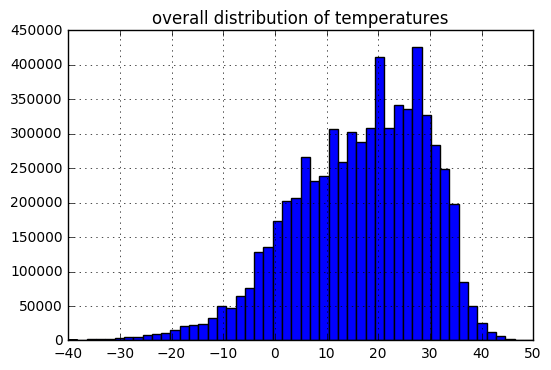

In [9]:
# compute the histogram
tmp=G.ix[:,:].unstack()
print shape(tmp), type(tmp)
tmp.hist(bins=50);
title('overall distribution of temperatures')
print tmp.min(),tmp.max()

### Script for plotting yearly plots ###

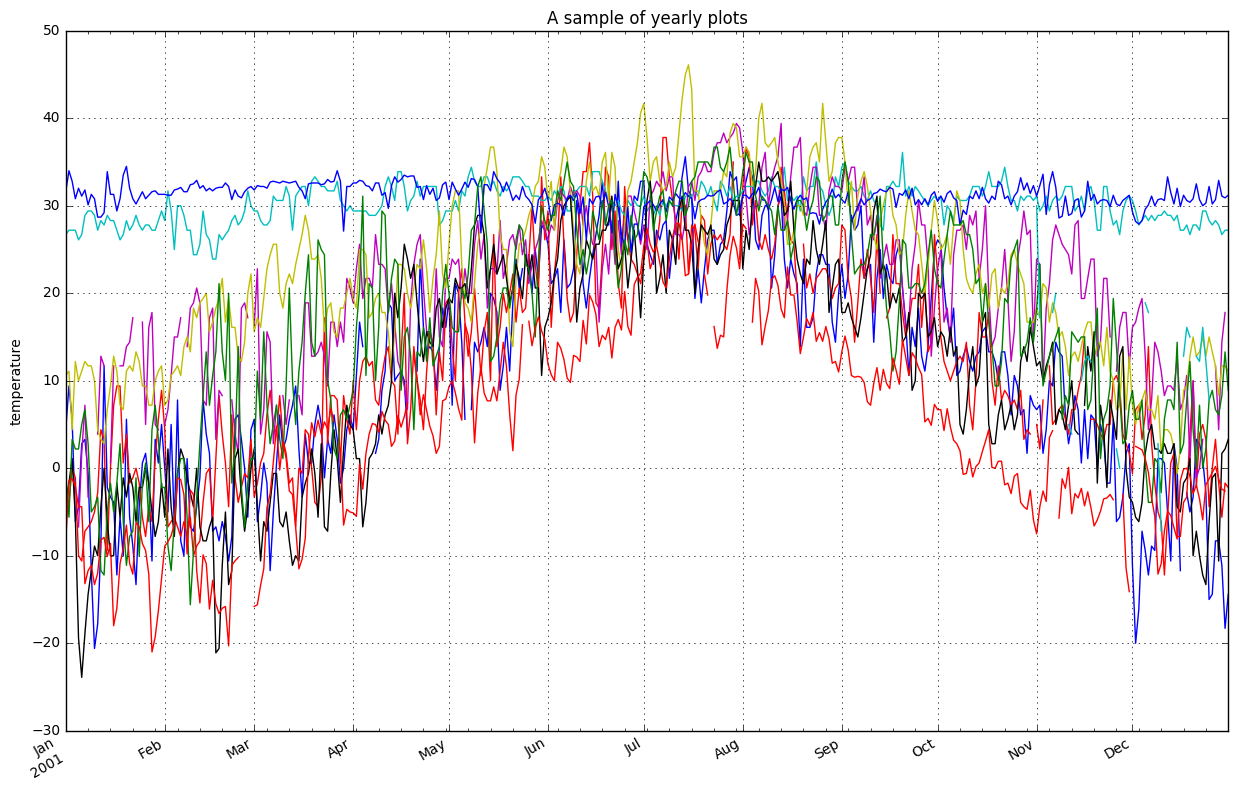

In [10]:
def YearlyPlots(T,ttl='',size=(15,10)):
    #fig, ax = plt.subplots(1)
    #print shape(T), shape(days), type(T)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    T.set_index(days_index)
    T.plot(legend=False,figsize=size)
    # rotate and align the tick labels so they look better
    gcf().autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.ix[20:30,days].transpose(),ttl='A sample of yearly plots')

### Plots for sydney, Australia ###

['ASN00066124' 'ASN00066059' 'ASN00066194' 'ASN00066131' 'ASN00066195'
 'ASN00066062']
(368, 6)


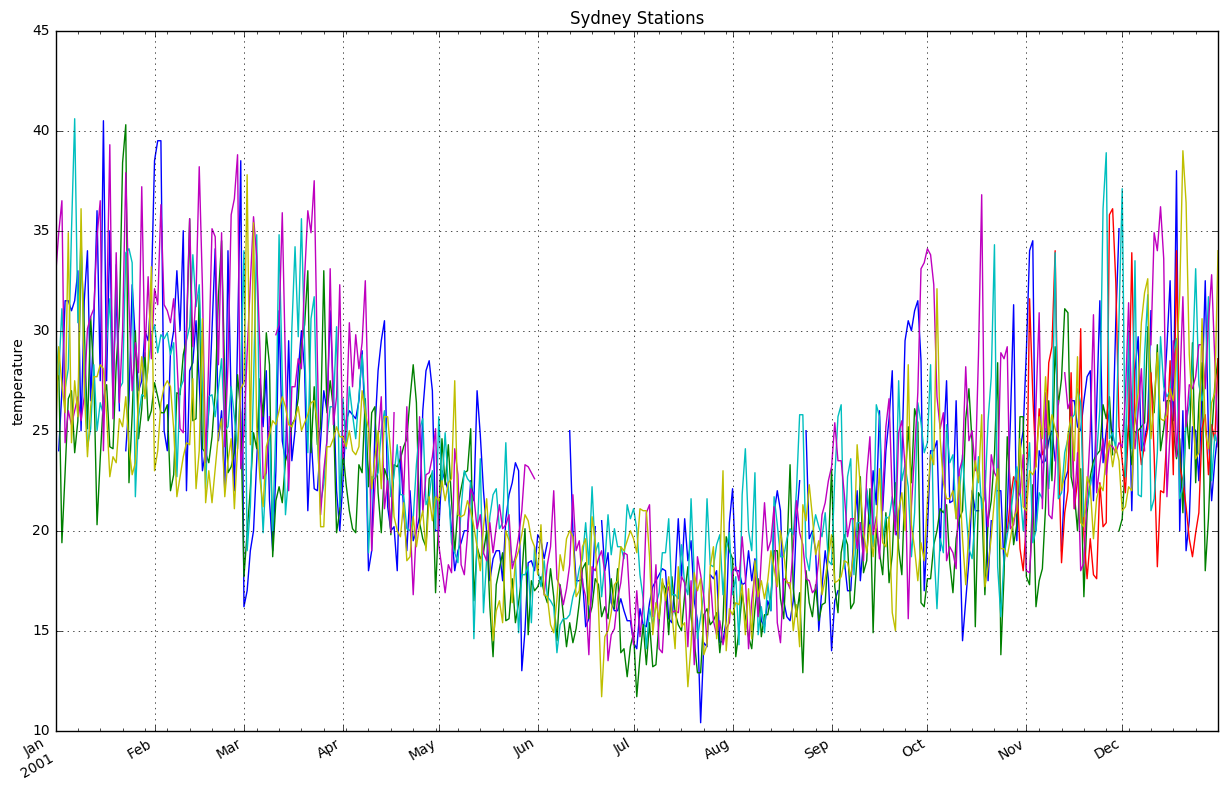

In [11]:
sydneyStations=['ASN00066' in station for station in Data['station']]
print Data[sydneyStations]['station'].values
tmp=Data[sydneyStations].transpose()
print shape(tmp)
YearlyPlots(tmp.ix[days,:],ttl='Sydney Stations')

### Computing mean and std for each station/year ###
And calculating the standard deviation for each year.

In [12]:
# a simple scale function to normalize the data-frame row-by-row
from numpy import mean, std
def Compute_mean_std(Din):
    matrix=Din.loc[:,days]
    Din['Mean']=mean(matrix, axis=1).values 
    Din['Std']=std(matrix, axis=1).values
    return Din

if 'measurement' in Data.columns:
    Data=Data.drop('measurement',axis=1)  # remove column that is the constant TMAX
Dout=Compute_mean_std(Data)
#reorder the columns
Dout=Dout[['station','year','Mean','Std']+days]
Dout.head()

,station,year,Mean,Std,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,2005,8.531507,10.439819,6.7,4.4,6.1,1.7,-1.7,-2.2,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,1959,14.494545,7.974400,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,1982,7.220513,14.897310,NaN,NaN,-13.9,NaN,NaN,-4.5,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,1964,18.576860,10.790115,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,1981,31.321370,1.588618,30.0,28.3,30.0,30.0,28.3,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


### Compute average temperature for each day of the year. ###

(365, 1)

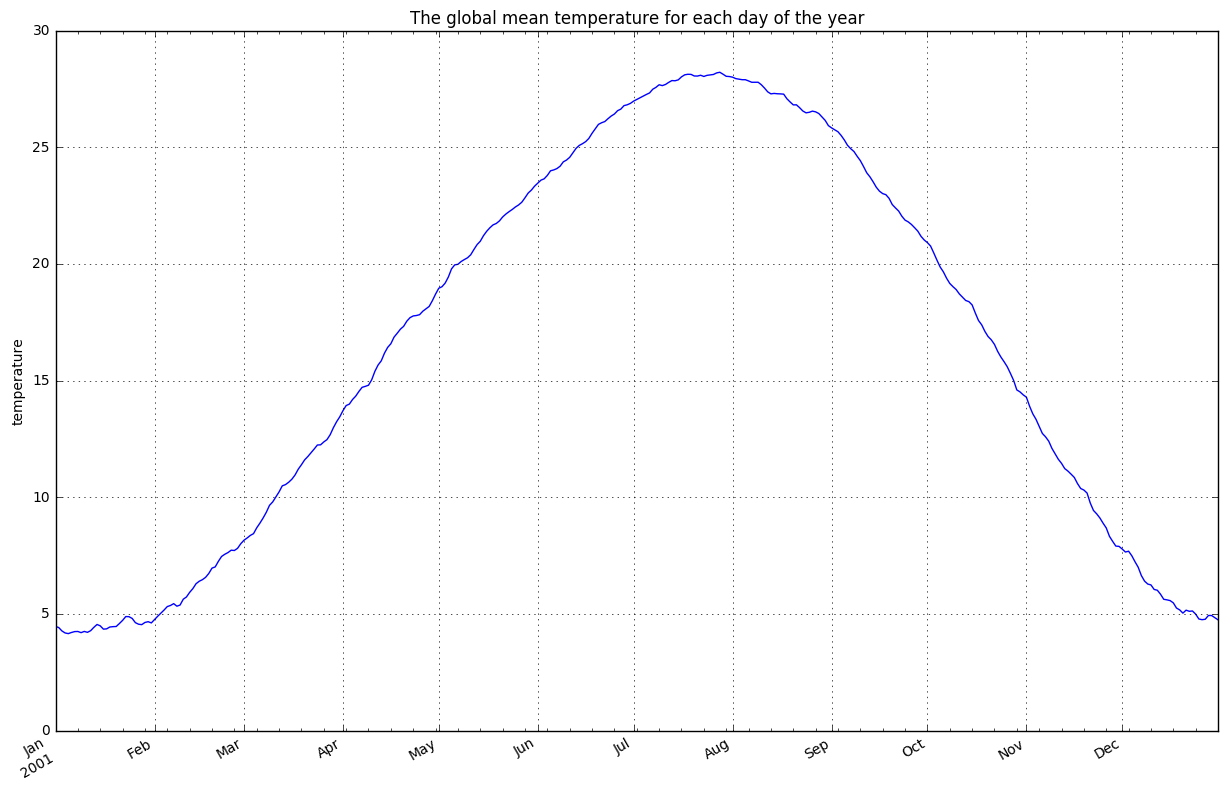

In [13]:
Mean=pd.DataFrame(mean(Dout.ix[:,days], axis=0))
#Mean=mean(Dout.ix[:,days], axis=0)
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')
shape(Mean)

In [14]:
pd.DataFrame.set_axis?

### SVD ###

### Missing Values ###
We find the distribution of missing values and decide how to deal with them. From the analysis below we see that most rows have some
missing values. We therefor choose to perform the average more carefully, rather than discard rows with many missing values

3760

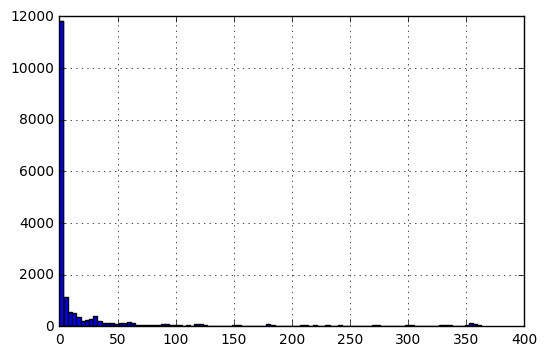

In [15]:
nan_per_row=sum(isnan(Dout.ix[:,1:365]),axis=1)
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

### NaN-tolerant averaging  ###
We compute the empirical covariance matrix in a way that tolerates NaN values.

<span style="color:red"> In the code below I remove all rows that have a nan in them. If you remve the command **M.dropna(...** then all rows are used. Can you get better results without removing the rows? </span>

In [16]:
sum(nan_per_row>50)

3760

In [17]:
max_nan=50

M=Dout.loc[:,days].transpose()
#M.drop(nan_per_row>0,axis=1,inplace=True)
M=M.ix[:,nan_per_row<max_nan]
Dout=Dout.ix[nan_per_row<max_nan,:]
Dout.index=range(shape(Dout)[0])
(columns,rows)=shape(M)
Mean=mean(M, axis=1).values

print (columns,rows), shape(Mean),shape(M),shape(Dout)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries
Dout.head()

(365, 16217) (365,) (365, 16217) (16217, 369)


,station,year,Mean,Std,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,2005,8.531507,10.439819,6.7,4.4,6.1,1.7,-1.7,-2.2,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,CUW00011706,1981,31.321370,1.588618,30.0,28.3,30.0,30.0,28.3,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1
2,SZ000002220,1994,2.395342,6.694865,-5.8,-2.8,-1.7,-5.0,-6.1,-3.9,...,-13.0,-4.8,-3.4,-4.4,-6.6,-3.4,-1.3,2.9,-2.8,-7.5
3,RSM00028275,1986,3.972877,14.084255,-11.4,-4.1,-2.2,-15.0,-16.7,-11.3,...,-31.5,-28.2,-23.6,-25.4,-25.9,-25.9,-29.5,-26.8,-22.5,-18.6
4,USC00488705,1982,12.107945,11.888948,1.1,-3.3,-4.4,-0.6,-2.2,-13.9,...,5.6,6.1,3.3,-3.9,0.6,-2.8,-8.3,-7.2,-6.7,-2.2


In [18]:
#%%time
for i in range(rows):
    if i % 1000==0: 
        print i
    row=M.iloc[:,i]-Mean;
    outer=np.outer(row,row)
    valid=isnan(outer)==False
    C[valid]=C[valid]+outer[valid]  # update C with the valid location in outer
    N[valid]=N[valid]+1
#valid_outer=np.multiply(1-isnan(N),N>0)
cov=np.divide(C,N)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [19]:
shape(cov)

(365, 365)

In [20]:
U,D,V=np.linalg.svd(cov)

In [21]:
shape(U),shape(D),shape(V)

((365, 365), (365,), (365, 365))

### Percentage of variance Explained ###

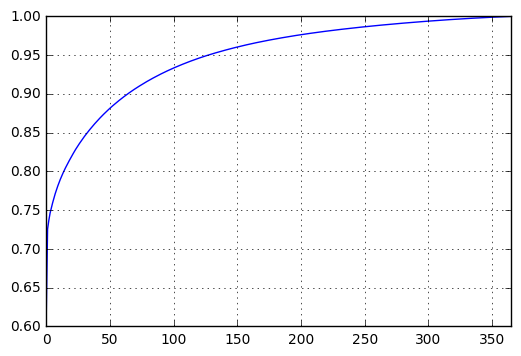

In [22]:
plot(cumsum(D[:])/sum(D))
xlim([0,365])
grid()

(365, 5)


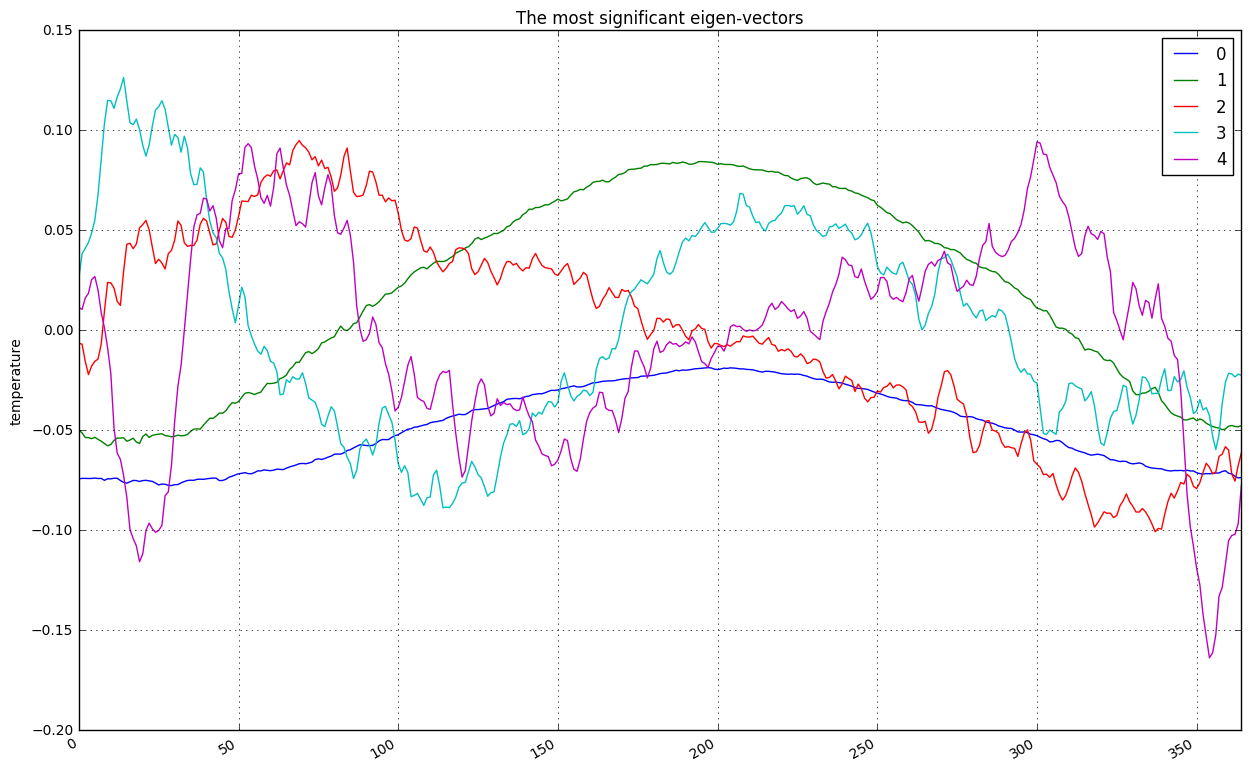

In [23]:
k=5 # number of components to show.
DF_U=pd.DataFrame(U[:,:k])
print shape(DF_U)
YearlyPlots(DF_U,ttl='The most significant eigen-vectors')
legend(range(0,k));

In [24]:
k=5
Eig=np.matrix(U[:,:k])
print 'checking that the norm of the eigenvectors is always 1'
print ['%6.3f,'%np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,days])-Mean.transpose()

#replacing nans with zeros
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

checking that the norm of the eigenvectors is always 1
[' 1.000,', ' 1.000,', ' 1.000,', ' 1.000,', ' 1.000,']
(365, 5) (16217, 365)
(16217, 5)


Insert coefficients for k top eigenvectors into the dataframe **Dout**

In [25]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

,station,year,Mean,Std,V0,V1,V2,V3,V4,2001-01-01 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,2005,8.531507,10.439819,142.859639,-55.173521,36.693058,-5.200370,-30.828625,6.7,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,CUW00011706,1981,31.321370,1.588618,-314.373311,-22.106199,-8.874564,-3.124461,-7.288273,30.0,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1
2,SZ000002220,1994,2.395342,6.694865,225.906786,-162.724665,-20.281424,3.413318,9.894655,-5.8,...,-13.0,-4.8,-3.4,-4.4,-6.6,-3.4,-1.3,2.9,-2.8,-7.5
3,RSM00028275,1986,3.972877,14.084255,253.079260,-8.846156,33.543871,-26.381500,26.869030,-11.4,...,-31.5,-28.2,-23.6,-25.4,-25.9,-25.9,-29.5,-26.8,-22.5,-18.6
4,USC00488705,1982,12.107945,11.888948,91.449871,0.821546,-1.467498,3.703292,3.225524,1.1,...,5.6,6.1,3.3,-3.9,0.6,-2.8,-8.3,-7.2,-6.7,-2.2


### Longitude,Latitude information ###
Loading the station longitude/latitude and merging it into the Table

In [26]:
!ls

ALL.corrupted.csv           ghcnd-readme.txt
ALL.head.csv                ghcnd-stations.txt
SAMPLE_TMAX.csv             ghcnd-stations_buffered.txt
TMAX.10.csv                 ghcnd-version.txt
TMAX.head.csv               make_covar.raw_256
data-source.txt


In [27]:
!cat ghcnd-readme.txt   # uncomment to read the readme file.

README FILE FOR DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 
Version 3.00

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

I. DOWNLOAD QUICK START

Start by downloading "ghcnd-stations.txt," which has metadata for all stations.

Then download one of the following TAR files:

  - "ghcnd-all.tar.gz" if you want all of GHCN-Daily, OR
  - "ghcnd-gsn.tar.gz" if you only want the GCOS Surface Network (GSN), OR
  - "ghcnd-hcn.tar.gz" if you only want the U.S. Historical Climatology Network 
    (U.S. HCN).

Then uncompress and untar the contents of the tar file, 
e.g., by using the following Linux command:

tar xzvf ghcnd_xxx.tar.gz

Where "xxx" stands for "all", "hcn", or "gsn" as applicable. The files will be 
extracted into a subdirectory under the directory where the command is issued.

ALTERNATIVELY, if you only need data for one station:

  - Find the station's

In [28]:
# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()

In [29]:
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

In [30]:
#stations['elevation'][stations['elevation']==-999.9]=0  # decided not to remove -999.9 because this confuses hist

In [31]:
stations.head()

,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


### perform a **JOIN** ###
Join the geographical information into **Dout**, creating a new dataframe called **Djoined**

In [32]:
Djoined=Dout.join(stations,on='station')

In [33]:
Djoined.columns

Index([         u'station',             u'year',             u'Mean',
                    u'Std',               u'V0',               u'V1',
                     u'V2',               u'V3',               u'V4',
       2001-01-01 00:00:00,
       ...
       2001-12-30 00:00:00, 2001-12-31 00:00:00,         u'latitude',
              u'longitude',        u'elevation',            u'state',
                   u'name',          u'GSNFLAG',          u'HCNFLAG',
                  u'WMOID'],
      dtype='object', length=382)

In [34]:
Djoined['AbsLatitude']=abs(Djoined['latitude'].values)

In [35]:
Djoined.ix[:5,['station',u'longitude','latitude',u'elevation',u'AbsLatitude','Mean','Std','V0','V1','V2']]

,station,longitude,latitude,elevation,AbsLatitude,Mean,Std,V0,V1,V2
0,USC00507570,-154.3164,60.2036,79.2,60.2036,8.531507,10.439819,142.859639,-55.173521,36.693058
1,CUW00011706,-75.1500,19.9000,16.2,19.9000,31.321370,1.588618,-314.373311,-22.106199,-8.874564
2,SZ000002220,9.3500,47.2500,2502.0,47.2500,2.395342,6.694865,225.906786,-162.724665,-20.281424
3,RSM00028275,68.2500,58.1500,44.0,58.1500,3.972877,14.084255,253.079260,-8.846156,33.543871
4,USC00488705,-104.3567,44.4122,1431.0,44.4122,12.107945,11.888948,91.449871,0.821546,-1.467498
5,USC00203991,-87.8667,46.4833,468.2,46.4833,8.421170,13.209237,166.017832,6.983121,-20.408843


### Looking for significant correlations and dependencies ###

In [36]:
Reduced=Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']]
Reduced.cov()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,333.386816,689.886797,-77.688711,31.506288,1787.161898,510.756377,-12.346024,39.770731,-10.697068
elevation,689.886797,387611.225058,-560.502007,174.902051,11399.536421,108.371690,1140.227887,2575.519048,871.637363
Mean,-77.688711,-560.502007,50.380849,-13.720151,-993.347472,71.441525,2.256328,0.110943,1.978315
Std,31.506288,174.902051,-13.720151,9.318992,314.999460,90.911734,2.083452,-2.972772,-0.658043
V0,1787.161898,11399.536421,-993.347472,314.999460,20181.402515,-35.995568,-52.167755,1.732165,-43.322627
V1,510.756377,108.371690,71.441525,90.911734,-35.995568,3495.453407,-1.583317,-4.106764,-1.565305
V2,-12.346024,1140.227887,2.256328,2.083452,-52.167755,-1.583317,393.616027,4.180096,6.572526
V3,39.770731,2575.519048,0.110943,-2.972772,1.732165,-4.106764,4.180096,323.144432,-1.170630
V4,-10.697068,871.637363,1.978315,-0.658043,-43.322627,-1.565305,6.572526,-1.170630,237.811465


<span style="color:red"> The correlations between different $V_i$ components should be zero, which it isn't.
Is this due to numerical roundoff errors? Are the correlations statistically significant for this sample size? </span>

In [37]:
Reduced.corr()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,1.000000,0.060688,-0.599447,0.565247,0.688992,0.473138,-0.034081,0.121169,-0.037990
elevation,0.060688,1.000000,-0.126837,0.092026,0.128888,0.002944,0.092312,0.230127,0.090786
Mean,-0.599447,-0.126837,1.000000,-0.633201,-0.985128,0.170242,0.016023,0.000869,0.018074
Std,0.565247,0.092026,-0.633201,1.000000,0.726356,0.503714,0.034400,-0.054172,-0.013978
V0,0.688992,0.128888,-0.985128,0.726356,1.000000,-0.004286,-0.018509,0.000678,-0.019775
V1,0.473138,0.002944,0.170242,0.503714,-0.004286,1.000000,-0.001350,-0.003864,-0.001717
V2,-0.034081,0.092312,0.016023,0.034400,-0.018509,-0.001350,1.000000,0.011721,0.021482
V3,0.121169,0.230127,0.000869,-0.054172,0.000678,-0.003864,0.011721,1.000000,-0.004223
V4,-0.037990,0.090786,0.018074,-0.013978,-0.019775,-0.001717,0.021482,-0.004223,1.000000


In [38]:
# Choosing significance threshold so that none of the correlations between the Vi-s are significant.
abs(Reduced.corr())>0.2

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,True,False,True,True,True,True,False,False,False
elevation,False,True,False,False,False,False,False,True,False
Mean,True,False,True,True,True,False,False,False,False
Std,True,False,True,True,True,True,False,False,False
V0,True,False,True,True,True,False,False,False,False
V1,True,False,False,True,False,True,False,False,False
V2,False,False,False,False,False,False,True,False,False
V3,False,True,False,False,False,False,False,True,False
V4,False,False,False,False,False,False,False,False,True


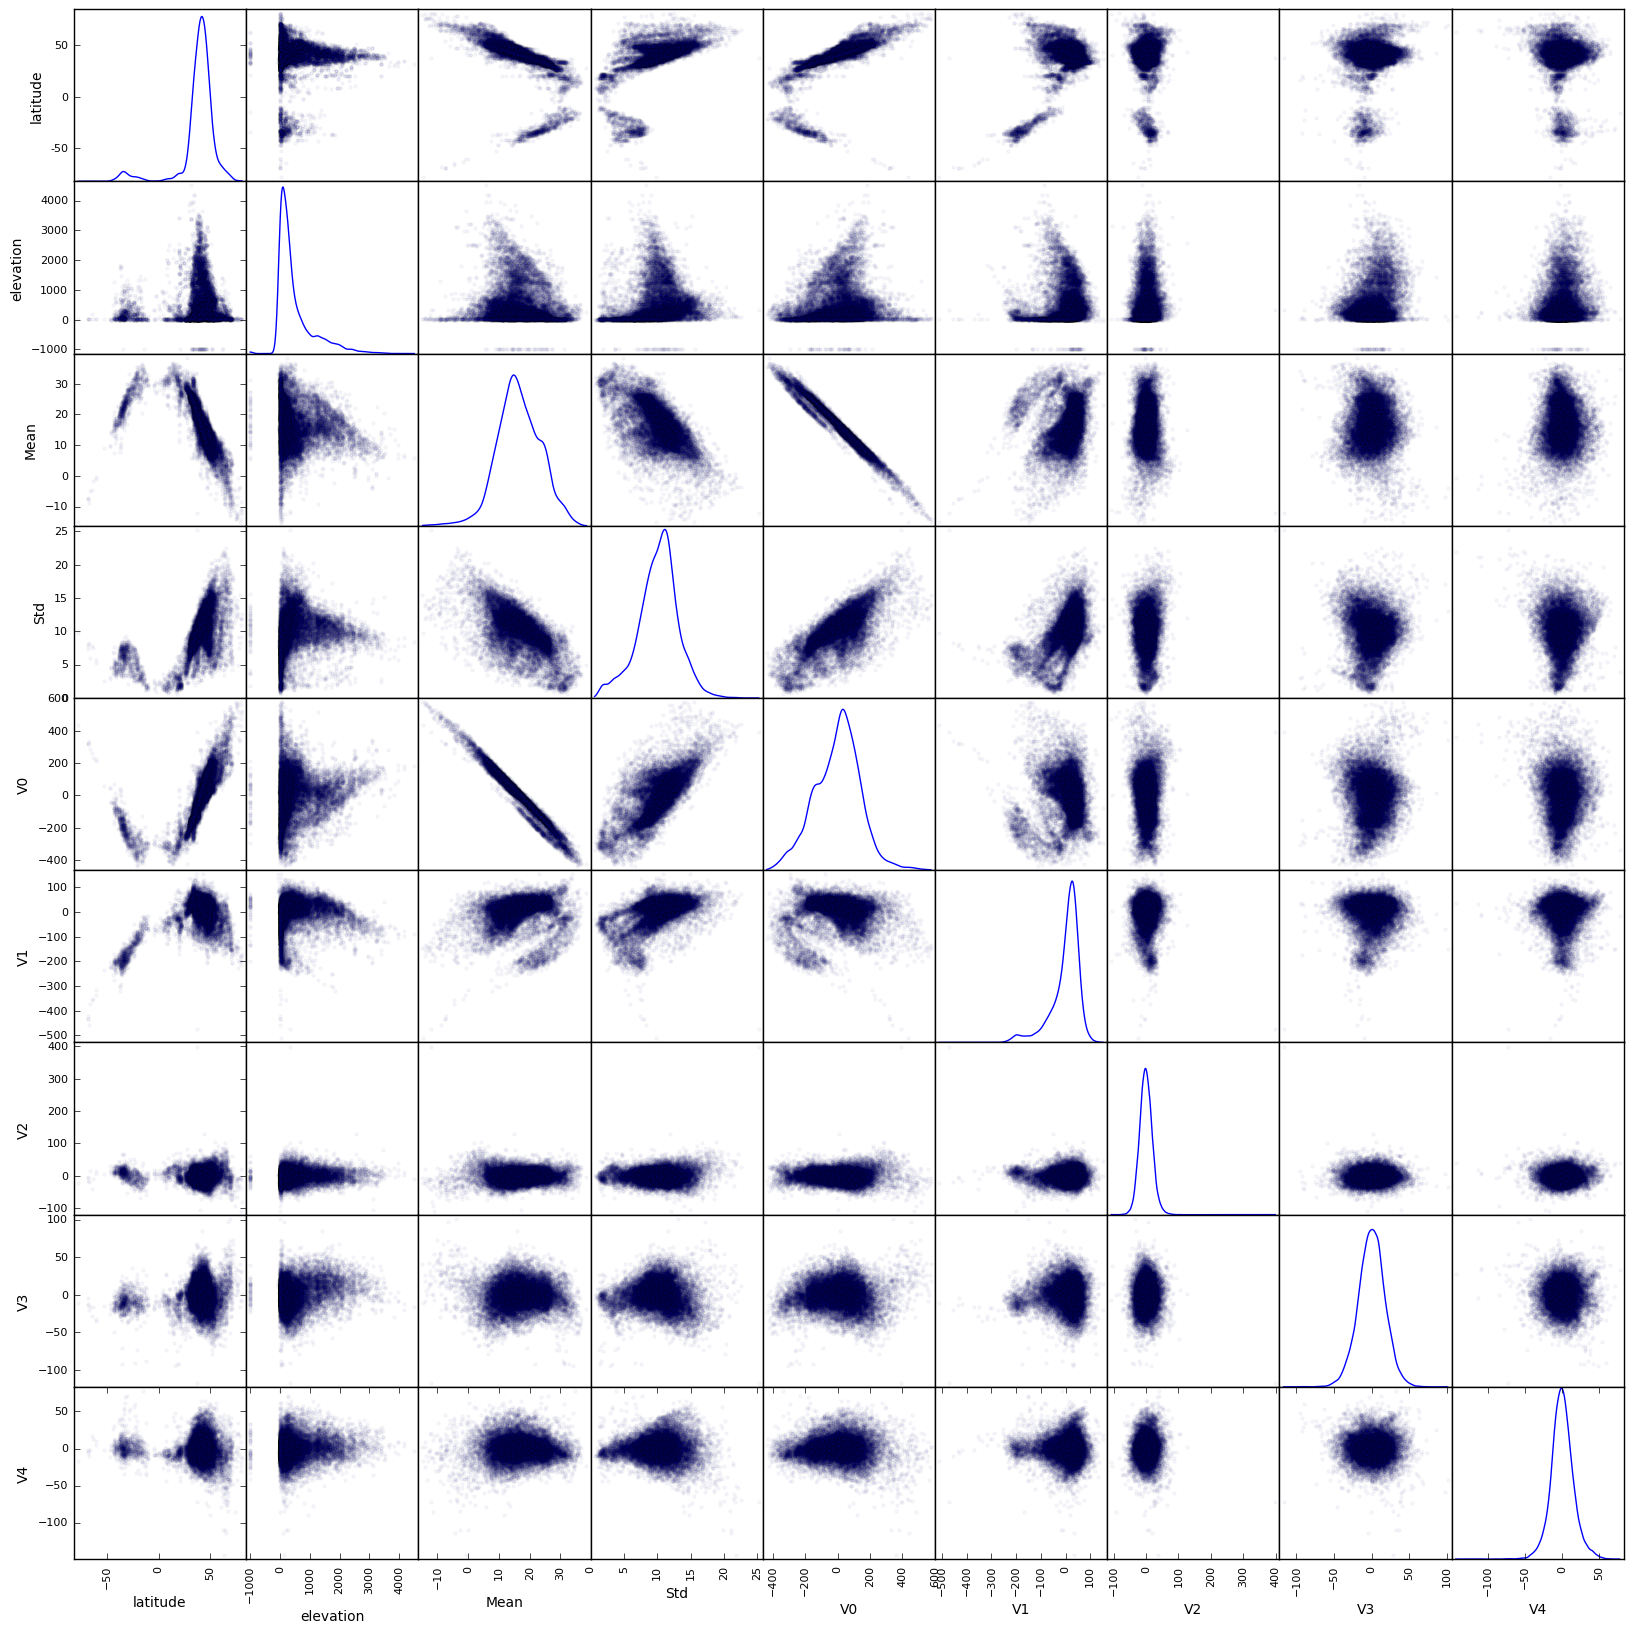

In [39]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(Reduced, alpha=0.03, figsize=(20, 20), diagonal='kde');

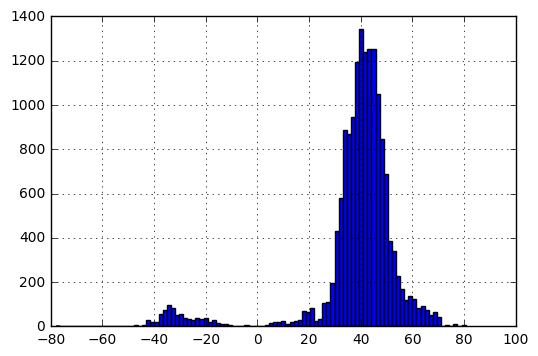

In [40]:
X='latitude'
Djoined.ix[:,X].hist(bins=100);

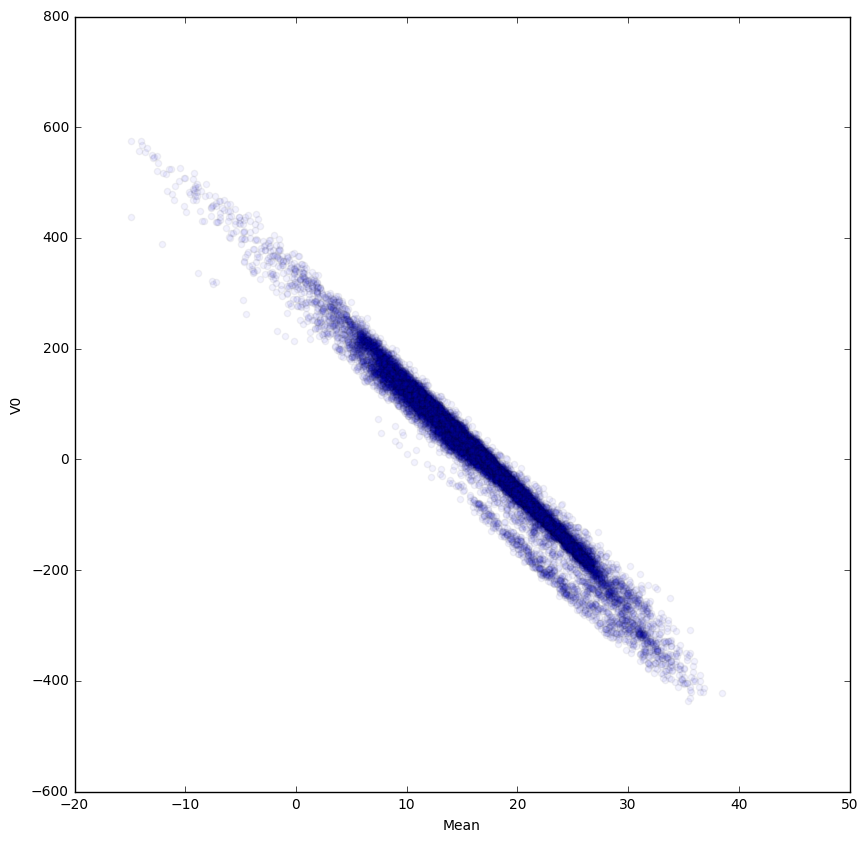

In [41]:
X='Mean';Y='V0'
figure(figsize=(10,10))
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)

In [42]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()

,station,elevation
1414,RSM00023707,-999.9
1795,USC00107878,-999.9
1812,USC00146746,-999.9
1903,BL000085141,-999.9
2358,USC00301010,-999.9


In [43]:
!grep ASN00010865 ghcnd-stations.txt

ASN00010865 -34.0333  117.2667 -999.9    LUMEAH                                      


### Plotting maps ###
Working through http://matplotlib.org/basemap/

* http://en.wikipedia.org/wiki/Map_projection
* http://matplotlib.org/basemap/users/mapsetup.html

In [44]:
lons=stations.ix[:,'longitude'].values
lats=stations.ix[:,'latitude'].values
station_names=stations.index.values
ll=len(lons)
lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
print sum(select)
station_names=station_names[select]
lons=lons[select]
lats=lats[select]
print len(lons),len(lats),len(station_names)

85273
85273 85273 85273


In [45]:
# http://matplotlib.org/basemap/users/merc.html

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'i' means use intermediate resolution coastlines.
plt.figure(figsize=(15,10),dpi=300)
m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
            llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# draw map with markers for locations
x, y = m(lons,lats)
m.plot(x,y,'g.')

plt.title('weather stations')
plt.show()


ImportError: No module named basemap

To get to these coordinate on Google Maps, type the latitude and longitude in decimal in the search box or use:
https://www.google.com/maps/place/72%C2%B018'00.0%22S+170%C2%B013'00.1%22E/@-72.3,170.216694,17z/data=!3m1!4b1!4m2!3m1!1s0x0:0x0

<span style="color:red">HW questions</span>

1. Waiting for somebody to write a script that will do that automatically from python
2. Can you create a map where the denity of points is represented as a density map (topographical map)?
3. Can you create a map that would represent, using color, the values of a chosen column (Mean, Std, V0,V1 etc.)? What conclusions can you draw from this map?


### Reconstruction ###

In [ ]:
KMean=np.array([Mean])

k=10
Keig=Eig[:,:k]
Kprod=Prod[:,:k]
Recon=pd.DataFrame(Kprod*Keig.transpose() +KMean)
Recon.columns=days_index

In [ ]:
print shape(Djoined.ix[i,days])
print shape(Recon.ix[i,days])

shape(Djoined),shape(Recon)

In [ ]:
def plot_reconstructions(selection,rows=2,columns=7,size=3):
    plt.figure(figsize=(columns*size,rows*size),dpi=300)
    j=1;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: 
            break
        (Djoined.ix[i,days]).plot()
        (Recon.ix[i,days]).plot()
        title(Djoined.ix[i,'station']+' / '+str(Djoined.ix[i,'year']))
plot_reconstructions(range(2000,2020),rows=10,columns=3,size=5)

Observe in the reconstructions below that the blue line fills in (extrapolation/interpolation) the places where the measurements are not available. It also reduces the fluctuations in the relative to the original line. Recall the we are using the k top eigenvectors which explain about 88% of the variance.

In [ ]:
plot_reconstructions([2012],rows=2,columns=2,size=8)

<span style="color:red"> Check how the approximations change/improve as you increase the number of coefficients</span>

In [ ]:
hist(Djoined.ix[:,'V0'],bins=100);

In [ ]:
selection= [i for i in range(shape(Djoined)[0]) if Djoined.ix[i,'latitude']<-10]
plot_reconstructions(selection,rows=7,columns=3)
shape(selection)

<span style="color:red">Can you reduce the reconstruction error (using a fixed number of eigenvectors) by splitting the stations according to region (for example country, state, latitudal range). Note that having a regions with very few readings defeats the purpose.

In [ ]:
shape(np.array([Mean]).transpose())